# Importing libraries and Data Loading

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from collections import Counter
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import nltk
from nltk.corpus import stopwords
import re

In [2]:
project_data = pd.read_csv("D:/DOWNLOADS/train_data.csv")
resource_data = pd.read_csv('D:/DOWNLOADS/resources.csv')

In [3]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   Unnamed: 0                                    109248 non-null  int64 
 1   id                                            109248 non-null  object
 2   teacher_id                                    109248 non-null  object
 3   teacher_prefix                                109245 non-null  object
 4   school_state                                  109248 non-null  object
 5   project_submitted_datetime                    109248 non-null  object
 6   project_grade_category                        109248 non-null  object
 7   project_subject_categories                    109248 non-null  object
 8   project_subject_subcategories                 109248 non-null  object
 9   project_title                                 109248 non-nu

In [4]:
project_data.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,12/5/2016 13:43,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,10/25/2016 9:22,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,8/31/2016 12:03,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,10/6/2016 21:16,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,7/11/2016 1:10,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


# Cleaning

# project_submitted_datetime

In [5]:
# Convert to datetime
project_data['project_submitted_datetime'] = pd.to_datetime(project_data['project_submitted_datetime'])

# Get the index of the column 'project_submitted_datetime'
column_index = project_data.columns.get_loc('project_submitted_datetime')

# Split components and insert them
project_data.insert(column_index, 'year', project_data['project_submitted_datetime'].dt.year)
project_data.insert(column_index + 1, 'month', project_data['project_submitted_datetime'].dt.month)
project_data.insert(column_index + 2, 'day', project_data['project_submitted_datetime'].dt.day)

# Drop the 'project_submitted_datetime' column
project_data = project_data.drop(columns=['project_submitted_datetime'])


# project_grade_category

In [6]:
project_grade_category = []

for i in range(len(project_data)):
    a = project_data["project_grade_category"][i].replace(" ", "_")
    project_grade_category.append(a)

project_data.drop("project_grade_category", axis=1, inplace=True)
project_data['project_grade_category']=project_grade_category

# project_subjects_category

In [7]:
## remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

#creating list in which elements are values of column 'project_subject_categories'
catogories = list(project_data['project_subject_categories'].values)

#preserving order of columns
cols = ['clean_catogory' if x=='project_subject_categories' else x for x in list(project_data.columns)]

#doing preprocessing of list categories(list of values of column 'project_subject_categories' )
removetable = str.maketrans('&', '_', '@#%!*$')
processed_list = [s.translate(removetable) for s in catogories]

removetable = str.maketrans('', '', ' ')
processed_list = [s.translate(removetable) for s in processed_list]
    
removetable = str.maketrans(',', ' ', '')
processed_list = [s.translate(removetable) for s in processed_list]

#removing column 'project_subject_categories'
project_data.drop('project_subject_categories', axis=1,inplace = True)

#adding column which is processed version of 'project_subject_categories', column by default added to the end of dataframe
project_data['clean_catogory']= processed_list

#re-ordering of columns
project_data = project_data[cols]

# project_subjects_subcategory

In [8]:
## remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

#creating list in which elements are values of column 'project_subject_subcategories'
sub_catogories = list(project_data['project_subject_subcategories'].values)

#preserving order of columns
cols = ['clean_subcatogory' if x=='project_subject_subcategories' else x for x in list(project_data.columns)]

#doing preprocessing of list categories(list of values of column 'project_subject_categories' )
removetable = str.maketrans('&', '_', '@#%!*$')
processed_list = [s.translate(removetable) for s in sub_catogories]

removetable = str.maketrans('', '', ' ')
processed_list = [s.translate(removetable) for s in processed_list]
    
removetable = str.maketrans(',', ' ', '')
processed_list = [s.translate(removetable) for s in processed_list]

#removing column 'project_subject_categories'
project_data.drop('project_subject_subcategories', axis=1,inplace = True)

#adding column which is processed version of 'project_subject_categories', column by default added to the end of dataframe
project_data['clean_subcatogory']= processed_list

#re-ordering of columns
project_data = project_data[cols]

In [9]:
project_data.head(5)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,year,month,day,clean_catogory,clean_subcatogory,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_grade_category
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016,12,5,Literacy_Language,ESL Literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Grades_PreK-2
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016,10,25,History_Civics Health_Sports,Civics_Government TeamSports,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,Grades_6-8
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016,8,31,Health_Sports,Health_Wellness TeamSports,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,Grades_6-8
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016,10,6,Literacy_Language Math_Science,Literacy Mathematics,Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,Grades_PreK-2
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016,7,11,Math_Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,Grades_PreK-2


# Clean:  Essays, project_title and  project_resource_summary (text columns)

In [10]:
#how do I insert a column at a specific column index in pandas?:https://stackoverflow.com/questions/18674064/how-do-i-insert-a-column-at-a-specific-column-index-in-pandas

# merging the essay columns 
#insert method does not insert column if it already exists
#project_data.drop('essay', axis=1,inplace = True)

essay = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

project_data.insert(loc=14,column='essay', value=essay)


project_data.drop('project_essay_1', axis=1,inplace = True)
project_data.drop('project_essay_2', axis=1,inplace = True)
project_data.drop('project_essay_3', axis=1,inplace = True)
project_data.drop('project_essay_4', axis=1,inplace = True)


In [11]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'year', 'month', 'day', 'clean_catogory', 'clean_subcatogory',
       'project_title', 'essay', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'project_grade_category'],
      dtype='object')

In [12]:

stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
              "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's",
              'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
              'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
              'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the',
               'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 
              'between', 'into', 'through', 'during', 'above', 'below', 'to', 'from', 
               'in', 'out', 'on', 'off', 'over', 'under',  'further', 'then', 'once', 'here', 
              'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',  'other',
               'than' , 's', 't', 'can', 'will',   'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'ma']


symbollist='"!@#$%^&*()+~[]{}' 
symboldict=dict.fromkeys(symbollist,"")
t=str.maketrans(symboldict) 

def clean(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase=phrase.replace("-", " ")
    phrase = re.sub('((http|https)\s*\:\s*\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', phrase)
    tag_clean = re.compile('<.*?>')
    phrase= re.sub(tag_clean, ' ', phrase)
    lowercase=[word.lower() for word in nltk.word_tokenize(phrase.translate(t)) if word.lower() not in stop_words and (word.isalpha() or word.isnumeric())]
    return lowercase


In [13]:
def clean_text_columns(column):
    corpus_clean = [clean(i) for i in tqdm(project_data[column])]
    list_clean_phrase = []

    for clean_review in tqdm(corpus_clean):
        list_clean_phrase.append(' '.join(word for word in clean_review))

    project_data[column] = list_clean_phrase
    return corpus_clean

corpus_clean_dict = {}

for column in ['project_title', 'essay', 'project_resource_summary']:
    corpus_clean_dict[column] = clean_text_columns(column)


100%|██████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 182272.62it/s]


In [14]:
project_data['project_title'].values[2]

'soccer equipment awesome middle school students'

In [15]:
project_data['project_resource_summary'].values[2]

'students need shine guards athletic socks soccer balls goalie gloves and training materials upcoming soccer season'

In [16]:
project_data['essay'].values[20000]

'kindergarten students varied disabilities ranging speech and language delays cognitive delays motor delays autism eager beavers and always strive work hardest working past limitations materials ones seek students teach title school most students receive free reduced price lunch despite disabilities and limitations students love coming school and come eager learn and ever felt like ants pants and needed groove and move meeting kids feel time want able move learn so chairs answer and love develop core enhances gross motor and turn fine motor skills also want learn games kids not want sit and worksheets want learn count jumping and playing physical engagement key success number toss and color and shape mats make happen students forget work and just fun 6 year old'

In [17]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   Unnamed: 0                                    109248 non-null  int64 
 1   id                                            109248 non-null  object
 2   teacher_id                                    109248 non-null  object
 3   teacher_prefix                                109245 non-null  object
 4   school_state                                  109248 non-null  object
 5   year                                          109248 non-null  int64 
 6   month                                         109248 non-null  int64 
 7   day                                           109248 non-null  int64 
 8   clean_catogory                                109248 non-null  object
 9   clean_subcatogory                             109248 non-nu

In [18]:
# merge the data:

# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

# join two dataframes in python: 
df = pd.merge(project_data, price_data, on='id', how='left')
df.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,year,month,day,clean_catogory,clean_subcatogory,project_title,essay,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,project_grade_category,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016,12,5,Literacy_Language,ESL Literacy,educational support english learners home,students english learners working english seco...,students need opportunities practice beginning...,0,0,Grades_PreK-2,154.60000,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016,10,25,History_Civics Health_Sports,Civics_Government TeamSports,wanted projector hungry learners,students arrive school eager learn polite gene...,students need projector help viewing education...,7,1,Grades_6-8,299.00000,1


# Train Test Split

In [19]:
#below code is to balanced our dataset
not_approved = df.loc[df['project_is_approved'] == 0]
approved = df.loc[df['project_is_approved'] == 1]
sample_positive = approved.take(np.random.permutation(len(approved))[:17000])
df = pd.concat([not_approved , sample_positive]).sort_index(kind='merge')

In [20]:
y = df['project_is_approved'].values# returns the array
df.drop(['project_is_approved'], axis=1, inplace=True)
X = df# X is a dataframe

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.30, random_state=123)

In [22]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(23479, 17)
(23479,)
(10063, 17)
(10063,)


# Vectorization

In [23]:
#vectorize clean_category

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['clean_catogory'].values:
    my_counter.update(word.split())
    
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)

X_train_categories_one_hot = vectorizer.fit_transform(X_train['clean_catogory'].values)
#X_cv_categories_one_hot = vectorizer.transform(X_cv['clean_catogory'].values)
X_test_categories_one_hot = vectorizer.transform(X_test['clean_catogory'].values)
                     
print(vectorizer.get_feature_names())
print("Shape of matrix for X_train after one hot encodig ",X_train_categories_one_hot.shape)
#print("Shape of matrix for X_cv after one hot encodig ",X_cv_categories_one_hot.shape)
print("Shape of matrix for X_test after one hot encodig ",X_test_categories_one_hot.shape)



['Warmth', 'Care_Hunger', 'History_Civics', 'Music_TheArts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix for X_train after one hot encodig  (23479, 9)
Shape of matrix for X_test after one hot encodig  (10063, 9)


In [24]:
#vectorize clean_sub_catogory

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['clean_subcatogory'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)

X_train_sub_categories_one_hot = vectorizer.fit_transform(X_train['clean_subcatogory'].values)
#X_cv_sub_categories_one_hot = vectorizer.transform(X_cv['clean_subcatogory'].values)
X_test_sub_categories_one_hot = vectorizer.transform(X_test['clean_subcatogory'].values)


print("Shape of matrix for X_train after one hot encodig ",X_train_sub_categories_one_hot.shape)
#print("Shape of matrix for X_cv after one hot encodig ",X_cv_sub_categories_one_hot.shape)
print("Shape of matrix for X_test after one hot encodig ",X_test_sub_categories_one_hot.shape)

Shape of matrix for X_train after one hot encodig  (23479, 30)
Shape of matrix for X_test after one hot encodig  (10063, 30)


In [25]:
#teacher_prefix_list = list(project_data['teacher_prefix'].values)

#teacher_prefix_processed_list=[x.replace(".","") for x in teacher_prefix_list]

# removing NAN values from 'teacher_prefix'
X_train['teacher_prefix']=X_train['teacher_prefix'].fillna("")
#X_cv['teacher_prefix']=X_cv['teacher_prefix'].fillna("")
X_test['teacher_prefix']=X_test['teacher_prefix'].fillna("")

In [26]:
#vectorize teacher_prefix

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['teacher_prefix'].values:
    my_counter.update(word.split())
    
teacher_prefix_dict = dict(my_counter)
sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv: kv[1]))

vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_prefix_dict.keys()), lowercase=False, binary=True)

X_train_teacher_prefix_one_hot = vectorizer.fit_transform(X_train['teacher_prefix'].values)
#X_cv_teacher_prefix_one_hot = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_one_hot = vectorizer.transform(X_test['teacher_prefix'].values)

print(vectorizer.get_feature_names())
print("Shape of matrix for X_train after one hot encodig ",X_train_teacher_prefix_one_hot.shape)
#print("Shape of matrix for X_cv after one hot encodig ",X_cv_teacher_prefix_one_hot.shape)
print("Shape of matrix for X_test after one hot encodig ",X_test_teacher_prefix_one_hot.shape)


['Dr.', 'Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix for X_train after one hot encodig  (23479, 5)
Shape of matrix for X_test after one hot encodig  (10063, 5)


In [27]:
#vectorize project_grade_category

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['project_grade_category'].values:
    my_counter.update(word.split())
    
project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True)

X_train_project_grade_category_one_hot = vectorizer.fit_transform(X_train['project_grade_category'].values)
#X_cv_project_grade_category_one_hot = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_one_hot = vectorizer.transform(X_test['project_grade_category'].values)

print(vectorizer.get_feature_names())
print("Shape of matrix for X_train after one hot encodig ",X_train_project_grade_category_one_hot.shape)
#print("Shape of matrix for X_cv after one hot encodig ",X_cv_project_grade_category_one_hot.shape)
print("Shape of matrix for X_test after one hot encodig ",X_test_project_grade_category_one_hot.shape)



['Grades_9-12', 'Grades_6-8', 'Grades_3-5', 'Grades_PreK-2']
Shape of matrix for X_train after one hot encodig  (23479, 4)
Shape of matrix for X_test after one hot encodig  (10063, 4)


In [28]:
#vectorize school_state

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in X_train['school_state'].values:
    my_counter.update(word.split())
    
school_state_dict = dict(my_counter)
sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))

vectorizer = CountVectorizer(vocabulary=list(sorted_school_state_dict.keys()), lowercase=False, binary=True)

X_train_school_state_one_hot = vectorizer.fit_transform(X_train['school_state'].values)
#X_cv_school_state_one_hot = vectorizer.transform(X_cv['school_state'].values)
X_test_school_state_one_hot = vectorizer.transform(X_test['school_state'].values)



print(vectorizer.get_feature_names())
print("Shape of matrix for X_train after one hot encodig ",X_train_school_state_one_hot.shape)
#print("Shape of matrix for X_cv after one hot encodig ",X_cv_school_state_one_hot.shape)
print("Shape of matrix for X_test after one hot encodig ",X_test_school_state_one_hot.shape)



['VT', 'WY', 'ND', 'DE', 'MT', 'RI', 'SD', 'NE', 'AK', 'NH', 'HI', 'NM', 'ME', 'WV', 'DC', 'IA', 'KS', 'ID', 'AR', 'CO', 'OR', 'KY', 'MN', 'MS', 'NV', 'MD', 'CT', 'AL', 'TN', 'WI', 'UT', 'VA', 'OH', 'WA', 'AZ', 'OK', 'MA', 'NJ', 'LA', 'MO', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'NY', 'TX', 'CA']
Shape of matrix for X_train after one hot encodig  (23479, 51)
Shape of matrix for X_test after one hot encodig  (10063, 51)


In [29]:
#Vectorize price

from sklearn.preprocessing import StandardScaler
# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

stand_scalar = StandardScaler()
stand_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {stand_scalar.mean_[0]}, Standard deviation : {np.sqrt(stand_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
X_train_price_standardized = stand_scalar.transform(X_train['price'].values.reshape(-1, 1))
#X_cv_price_standardized = stand_scalar.transform(X_cv['price'].values.reshape(-1, 1))
X_test_price_standardized = stand_scalar.transform(X_test['price'].values.reshape(-1, 1))



Mean : 325.00860769198005, Standard deviation : 389.6587892211485


In [30]:
#vectorize teacher_number_of_previously_posted_projects
stand_scalar = StandardScaler()
stand_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {stand_scalar.mean_[0]}, Standard deviation : {np.sqrt(stand_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
X_train_teacher_number_of_previously_posted_projects_standardized = stand_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
#X_cv_teacher_number_of_previously_posted_projects_standardized = stand_scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
X_test_teacher_number_of_previously_posted_projects_standardized = stand_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))



Mean : 9.725116061161037, Standard deviation : 25.096786877497777


In [31]:
# vectorize quantity
stand_scalar = StandardScaler()
stand_scalar.fit(X_train['quantity'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {stand_scalar.mean_[0]}, Standard deviation : {np.sqrt(stand_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
X_train_quantity_standardized = stand_scalar.transform(X_train['quantity'].values.reshape(-1, 1))
#X_cv_quantity_standardized = stand_scalar.transform(X_cv['quantity'].values.reshape(-1, 1))
X_test_quantity_standardized = stand_scalar.transform(X_test['quantity'].values.reshape(-1, 1))

#X_cv_quantity_standardized.shape

Mean : 18.23765918480344, Standard deviation : 27.006426461534577


In [32]:
#vectorize essay
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)

vectorizer.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
#X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

In [33]:
#vectorize project_title

vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['project_title'].values)

X_train_project_title_tfidf = vectorizer.transform(X_train['project_title'].values)
#X_cv_project_title_bow = vectorizer.transform(X_cv['project_title'].values)
X_test_project_title_tfidf = vectorizer.transform(X_test['project_title'].values)



In [34]:
#vectorize project_resource_summary

vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['project_resource_summary'].values)

X_train_project_resource_summary_tfidf = vectorizer.transform(X_train['project_resource_summary'].values)
#X_cv_project_resource_summary_bow = vectorizer.transform(X_cv['project_resource_summary'].values)
X_test_project_resource_summary_tfidf = vectorizer.transform(X_test['project_resource_summary'].values)


In [35]:
X_train_essay_tfidf.shape

(23479, 8823)

In [36]:
X_train_project_title_tfidf .shape

(23479, 1155)

In [37]:
X_train_project_resource_summary_tfidf.shape

(23479, 2524)

# Merging

In [38]:
from scipy.sparse import hstack

X_train_processed = hstack((X_train_essay_tfidf , X_train_project_title_tfidf ,X_train_project_resource_summary_tfidf,
                            X_train_categories_one_hot , X_train_sub_categories_one_hot ,X_train_teacher_prefix_one_hot,
                           X_train_project_grade_category_one_hot,X_train_school_state_one_hot,
                           X_train_price_standardized ,X_train_teacher_number_of_previously_posted_projects_standardized ,
                           X_train_quantity_standardized)).tocsr()




X_test_processed = hstack((X_test_essay_tfidf , X_test_project_title_tfidf ,X_test_project_resource_summary_tfidf,
                           X_test_categories_one_hot , X_test_sub_categories_one_hot ,X_test_teacher_prefix_one_hot,
                          X_test_project_grade_category_one_hot,X_test_school_state_one_hot,
                           X_test_price_standardized ,X_test_teacher_number_of_previously_posted_projects_standardized ,
                         X_test_quantity_standardized
                           )).tocsr()

In [41]:
X_test_processed.shape

(10063, 12604)

# Classification

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

classifier = RandomForestClassifier()
classifier.fit(X_train_processed, Y_train)

RandomForestClassifier()

In [43]:
Y_pred = classifier.predict(X_test_processed)

In [44]:
data = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})
data.head()

,Actual,Predicted
0,1,1
1,1,0
2,1,1
3,1,1
4,1,0


In [45]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_test, Y_pred)

0.661830468051277

In [46]:
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, Y_pred)
auc(test_fpr, test_tpr)


0.6619107194266657

In [49]:
a=np.where(data.Actual!=data.Predicted, data.index,None)
a=list(a)
a= filter(None, a)
a=list(a)

len(a)
# total misclassified points

3403

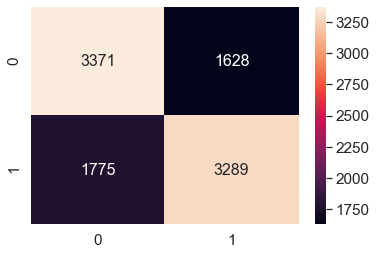

In [50]:
cm = pd.DataFrame(confusion_matrix(data['Actual'],data['Predicted']))

sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()
# actual on y axis, predicted on x axis

In [55]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_processed, Y_train)

LogisticRegression()

In [56]:
Y_pred = classifier.predict(X_test_processed)

In [57]:
data = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})
data.head()


,Actual,Predicted
0,1,1
1,1,0
2,1,0
3,1,1
4,1,0


In [58]:
accuracy_score(Y_test, Y_pred)

0.6590479976150253

In [59]:
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, Y_pred)
auc(test_fpr, test_tpr)

0.6590023178411354

In [1]:
# We can still improve the the auc score.